<a href="https://colab.research.google.com/github/rclUPC/AdvancedFluidMechanics/blob/main/2-Rheology/FDMViscoelastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Viscoelastic fluid in a pipe (Maxwell model)

We are going to consider the problem of transient flow of viscoelastic flow in a pipe.

The transient equation for laminar flow, with velocity only in axial direction ($u_y(t,r) = u(t,r))$ is

$$ \rho \frac{\partial u}{\partial t} = P + \frac{1}{r}\frac{\partial r\tau}{\partial r} \tag{1}$$

where we denote $P = -\frac{\partial p}{\partial z}$, where $z$ is the axis of the pipe.

For a **Newtonian flow**, stress tensor is computed with

$$ \tau = \eta \frac{\partial u}{\partial r} \tag{2}$$

and the solution is the well known [Hagen-Poiseuille flow](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation). However, if a **viscoelastic fluid** is considered, with the _Maxwell model_ the stress is computed with

$$ \tau + \lambda \frac{\partial \tau}{\partial t} = \eta \frac{\partial u}{\partial r} \tag{3}$$

where $\lambda$ is the relaxation time.

We can write this equations with dimensionless variables, by defining

$$
r^* = \frac{r}{R} \\
t^* = \frac{\eta}{\rho R^2}t \\
u^* = \frac{4\eta}{R^2P}u \\
\tau^* = \frac{4}{RP}\tau \\
\xi = \frac{\eta}{\rho R^2}\lambda
$$

With these variables, the dimensionless equations are (we drop the "*" for the sake of simplicity):

$$
\frac{\partial u}{\partial t} = 4 + \frac{\partial \tau}{\partial r} + \frac{\tau}{r} \tag{4}
$$
$$
\tau + \xi\frac{\partial \tau}{\partial t} = \frac{\partial u}{\partial r} \tag{5}
$$

The boundary conditions are:

$$ u(r=1) = 0 \;\forall t $$
$$ \left(\frac{\partial u}{\partial r}\right)_{r=0} = 0\;\forall t$$

and the initial conditions are

$$ u(r) = \tau(r) = 0 \;\text{for}\,t=0$$

This is a system of PDE that cannot be solved analytically (at least, not easily).

The easiest (for me, at least...) method is to use the [Finite Difference Method](https://en.wikipedia.org/wiki/Finite_difference_method) (FD) Method

Translating the previous equations to FD language, with explicit scheme, with central difference in space and forward in time, we get

$$
\frac{u_i^{n+1} - u_i^n}{\Delta t} = 4 + \frac{\tau_{i+1}^n - \tau_{i-1}^n}{2\Delta r} + \frac{\tau_i^n}{r_i} \tag{6}
$$
$$
\tau_i^n + \xi\frac{\tau_i^{n+1} - \tau_i^n}{\Delta t} = \frac{u_{i+1}^n-u_{i-1}^n}{2\Delta r} \tag{7}
$$

and, in terms of previous time step,

$$
u_i^{n+1} = u_i^n + \Delta t\left( 4 + \frac{\tau_{i+1}^n - \tau_{i-1}^n}{2\Delta r} + \frac{\tau_i^n}{r_i} \right) \tag{8}
$$
$$
\tau_i^{n+1} = \tau_i^n + \frac{\Delta t}{\xi}\left(\frac{u_{i+1}^n-u_{i-1}^n}{2\Delta r} - \tau_i^n  \right) \tag{9}
$$

For Newtonian:

$$ \tau_i^{n+1} = \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta r} \tag{10}$$

In [1]:
def uNew(u,tau,tauS,tauN,r):
    return (u + deltat*(4+(tauN-tauS)/(2*deltar)+tau/r))

def tauNew(tau,uS,uN):
    #return (xi/(xi+deltat)*tau+deltat/(2*deltar*(deltat+xi))*(uN-uS))
    return (tau + deltat/xi*((uN-uS)/(2*deltar)-tau))

def tauNewNew(uS,uN):
    return (1/(2*deltar)*(uN-uS))

In [2]:
import numpy as np

In [3]:
N = 21
deltar = 1/(N-1)
sigma = 0.001 # parameter for stability
deltat = sigma*deltar
T = 1 #dimensionless
K = int(T/deltat) + 1

In [4]:
uVE = np.zeros((N,K))
uNewtonian = uVE.copy()
tauVE = uVE.copy()
tauNewtonian = uVE.copy()

In [5]:
xi = 0.2
for k in range(1,K-1):
    for i in range(1,N-1):
        tauVE[i,k] = tauNew(tauVE[i,k-1],uVE[i-1,k-1],uVE[i+1,k-1])
        tauNewtonian[i,k] = tauNewNew(uNewtonian[i-1,k-1],uNewtonian[i+1,k-1])
    for i in range(1,N-1):
        uVE[i,k] = uNew(uVE[i,k-1],tauVE[i,k-1],tauVE[i-1,k-1],tauVE[i+1,k-1],i*deltar)
        uNewtonian[i,k] = uNew(uNewtonian[i,k-1],tauNewtonian[i,k-1],tauNewtonian[i-1,k-1],tauNewtonian[i+1,k-1],i*deltar)
    uVE[0,k] = uVE[1,k]
    uNewtonian[0,k] = uNewtonian[1,k]
    uVE[N-1,k] = 0
    uNewtonian[N-1,k] = 0
    tauVE[N-1,k] = tauNew(tauVE[N-1,k-1],uVE[N-2,k-1],2*uVE[N-1,k-1]-uVE[N-2,k-1])
    tauNewtonian[N-1,k] = tauNewNew(uNewtonian[N-2,k-1],2*uNewtonian[N-1,k-1]-uNewtonian[N-2,k-1])

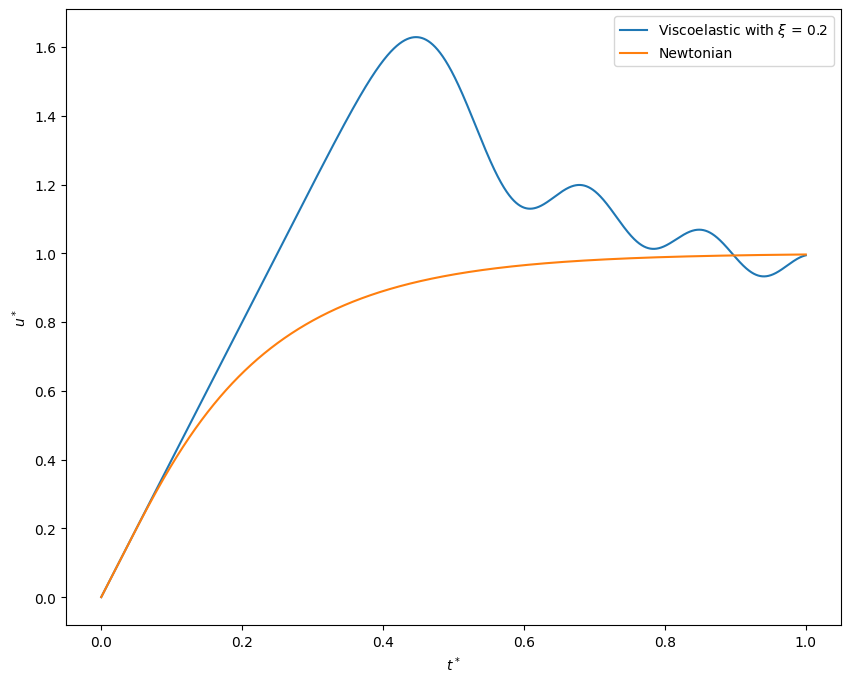

In [8]:
import matplotlib.pyplot as plt
t = np.arange(0,T,deltat)
plt.figure(figsize=(10,8))
plt.plot(t,uVE[0,:-1],label=r'Viscoelastic with $\xi$ = {}'.format(xi))
plt.plot(t,uNewtonian[0,:-1],label='Newtonian')
plt.xlabel(r'$t^*$')
plt.ylabel(r'$u^*$')
plt.legend();

## Exercise

Change the Maxwell model by the Voigth-Kelvin model and discuss the result